# Outline of project

* Dataset being imported
* Visualize some aspect of the dataset
* Create Train and Validation dataset
* Create Our Vocabulary and tokenizer
* Create the Model
* setup the training loop for the model
* Visualizatoin of model prediction

Metrics Blue, Earlystoping as per paper,  


## Imports

In [1]:
import numpy as np
import os, random
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from tqdm import tqdm
import torchsummary
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

## Data Visualization

As per dataset decription, each image has 5 captions avaialable let's see a few of them and how they look like

In [2]:
def load_dataset_dict(caption_path):
    df = pd.read_csv(caption_path)
    caption_dict = defaultdict(list)
    for _, row in df.iterrows():
        caption_dict[row.image].append(row.caption)
    return caption_dict

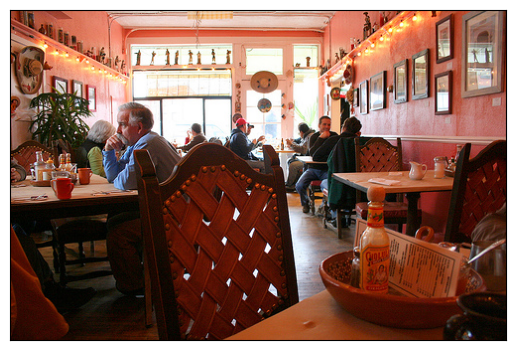

An empty seat at a Mexican themed restaurant .
A red colored diner features dark red chairs .
Crowded Mexican restaurant , empty chair in foreground .
Many people sit in a Mexican restaurant .
People are sitting in a cheery Mexican restaurant .


In [3]:
image_id, captions = random.choice(list(load_dataset_dict("data/captions.txt").items()))
data_dir = "data/images"
full_image_path = os.path.join(data_dir, image_id)
image = Image.open(full_image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()
for caption in captions:
    print(caption)


## EDA

In [4]:
df = pd.read_csv("data/captions.txt")
df_captions = df.caption

In [51]:
def count_words(df):
    vocabulary = []
    for txt in df.caption.values:
        vocabulary.extend(txt.split())
    counter = defaultdict(int)

    for word in vocabulary:
        counter[word.lower()] += 1
    sorted_items = sorted(counter.items(), key=lambda item: item[-1], reverse=True)


    df = pd.DataFrame(sorted_items, columns=['word', 'count'])

    return df

df_counter = count_words(df)

In [53]:
df_counter.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


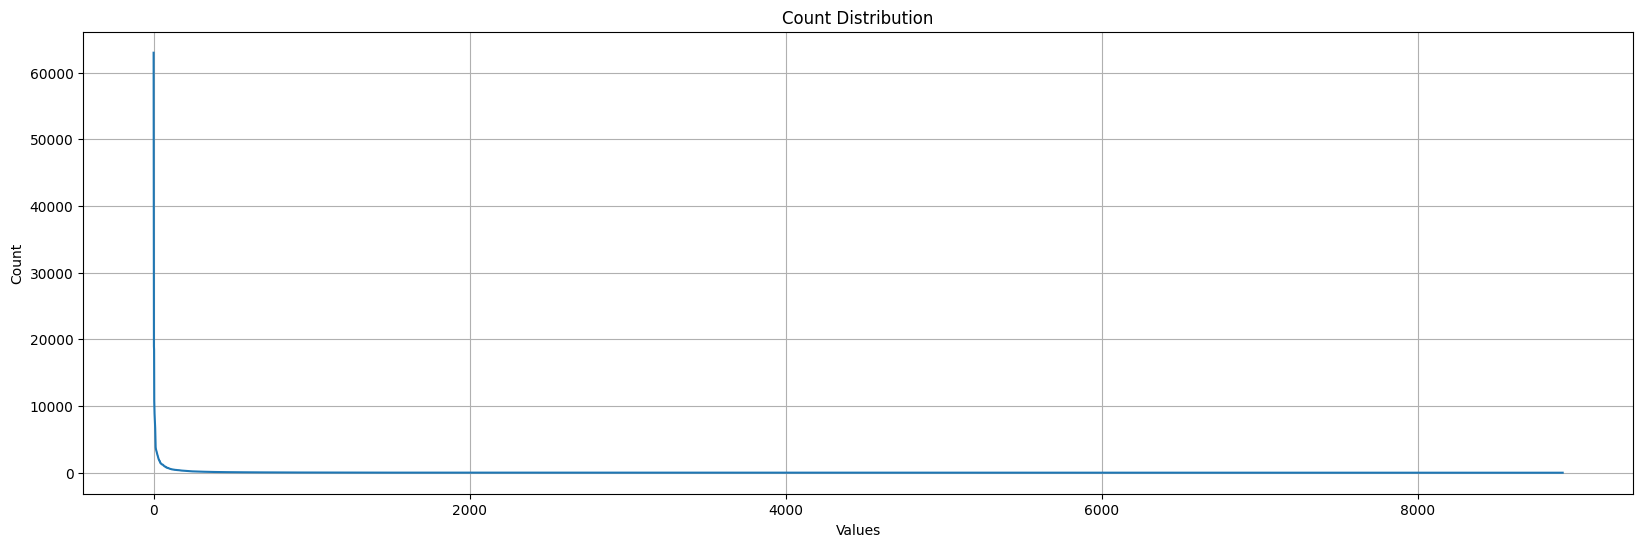

In [57]:
df_counter["count"].plot(grid=True, figsize=(20, 6))
plt.title("Count Distribution")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'plot of count vs words')

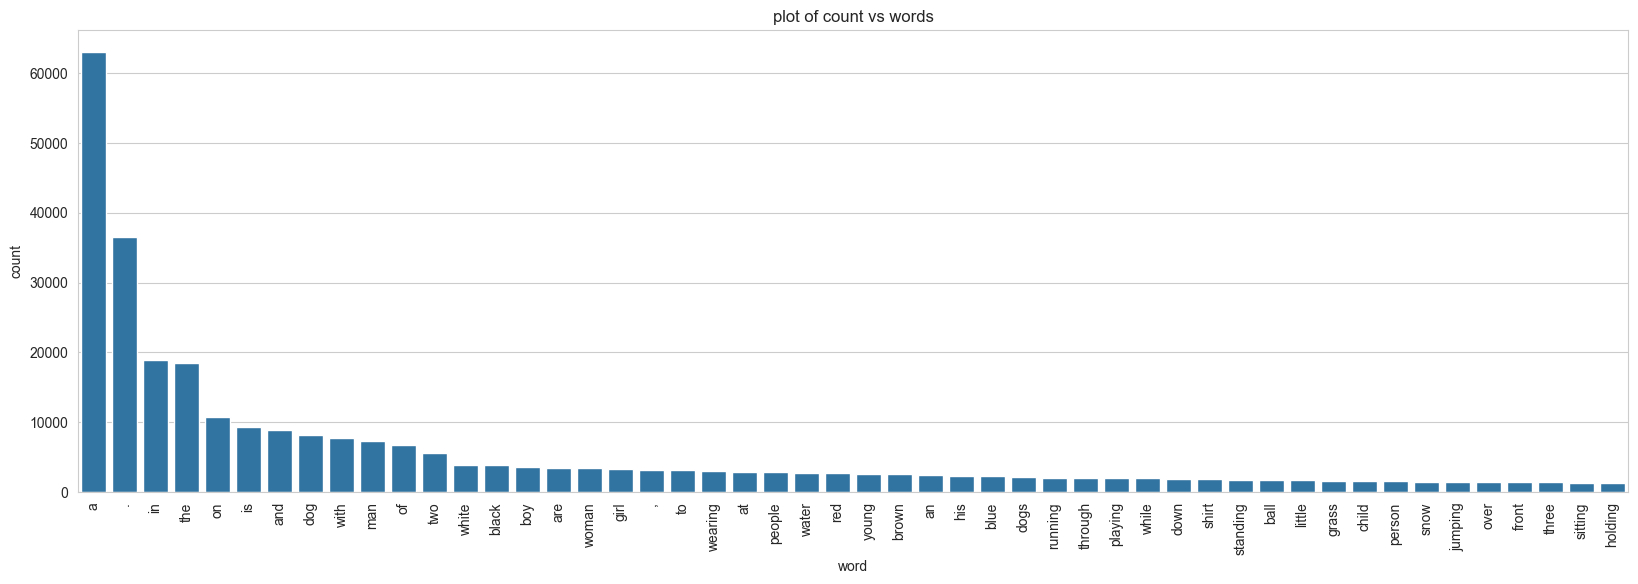

In [69]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_counter[:50], y='count', x="word")
plt.xticks(rotation="vertical")
plt.title("plot of count vs words")

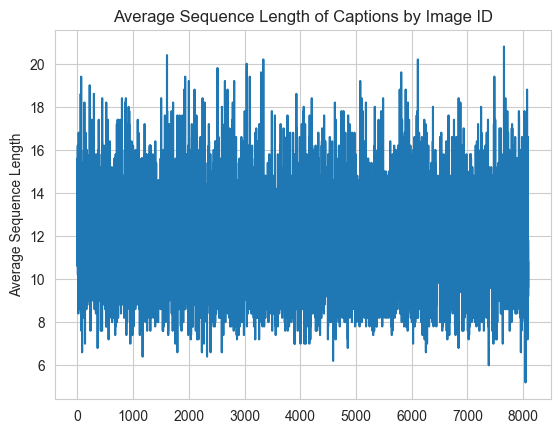

In [77]:
df['sequence_length'] = df['caption'].apply(lambda x: len(x.split()))

# Step 3: Group by 'image_id' and calculate the average sequence length
avg_sequence_length = df.groupby('image')['sequence_length'].mean().reset_index()
avg_sequence_length['sequence_length'].plot()
plt.ylabel('Average Sequence Length')
plt.title('Average Sequence Length of Captions by Image ID')
plt.show()

## Train, Val Split

In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [6]:
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [7]:
for i in train_data.values():
    for j in i:
        print(j)
    break

The three dogs are running around near the shore .
Three dogs are playing together on the sandy shore of a lake .
Three dogs play by a lake .
Three dogs play near the water .
Two smaller dogs chase a larger dog around a pond .


In [8]:
hash_map = {"a"}
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map.add(word.lower())
len(hash_map)


8031

In [9]:
hash_map_val = {"a"}
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map_val.add(word.lower())
len(hash_map_val)

8031

In [10]:
hash_map.difference(hash_map_val)

set()

In [11]:
hash_map_val.difference(hash_map)

set()

*Note*: all the words in train are also in out test data

## Vocabulary and tokenizer

In [ ]:
!python -m spacy download en_core_web_sm

In [12]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    
    def vocabulary_size(self):
        return len(self.stoi) - 4

In [13]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8504

In [15]:
vocabulary.tokenize("creates a human whose, name is not Tom James")

[5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]

In [16]:
vocabulary.stoi["<PAD>"]

0

In [64]:
class FlickrDataset(Dataset):

    def __init__(self, image_dir, vocabulary: Vocabulary, data_dict, transform=None, train=True):
        self.data_dict = data_dict
        self.transform = transform
        self.image_dir = image_dir


        self.train = train
        self.item = self.setup_item()
        
        self.vocabulary = vocabulary

    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                item.append((image_id, image_captions))
        return item

    def __len__(self):
        return len(self.item)


    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        caption = self.item[index][1]
        if self.train:
            num_caption = [self.vocabulary.stoi['<SOS>']]
            num_caption += self.vocabulary.tokenize(caption)
            num_caption.append(self.vocabulary.stoi['<EOS>'])
            num_caption = torch.tensor(num_caption)
            return img, num_caption
        else:
            captions = []
            for cap in caption:
                num_caption = [self.vocabulary.stoi['<SOS>']]
                num_caption += self.vocabulary.tokenize(cap)
                num_caption.append(self.vocabulary.stoi['<EOS>'])
                captions.append(torch.tensor(num_caption))
            return img, pad_sequence(captions, batch_first=True, padding_value=0)
        

In [79]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch): # pad sequnece
        img = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(img, 0)
        target = [item[1] for item in batch]
        target = pad_sequence(target, batch_first=True, padding_value=self.pad_idx)
            
        return img, target

In [80]:
def get_loader(
        image_folder,
        data_dict,
        vocabulary,
        transform,
        train=True,
        batch_size=32,
        num_worker=0,
        shuffle=True,
        pin_memory=True
):
    dataset = FlickrDataset(image_dir=image_folder, vocabulary=vocabulary, data_dict=data_dict,
                            transform=transform, train=train)
    pad_idx = vocabulary.stoi["<PAD>"]
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=MyCollate(pad_idx=pad_idx),
        pin_memory=pin_memory,
        shuffle=shuffle,
        num_workers=num_worker,
    )

    return loader, dataset

In [81]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8504

In [82]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [83]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [84]:
train_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=train_data,
                        transform=transform, train=True)

In [85]:
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([17])


In [86]:
val_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=val_data,
                        transform=transform, train=False)

In [87]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", len(random_label), random_label.shape)
## using list of sequence with training = False (not tensor and pad)

Random Shape: torch.Size([3, 224, 224])
Random Caption: 5 torch.Size([5, 17])


## Model

### Encoder

In [171]:
model = vgg19("VGG19_Weights.IMAGENET1K_V1")

#### Test

In [172]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [173]:
list(model.features.children())[:-1]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [162]:
# Path to your image file
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)

modules = list(model.features.children())[:-1]
test_model = nn.Sequential(*modules)

output = test_model(image_tensor)
print(output.shape)
print(image_tensor.shape)

torch.Size([1, 512, 14, 14])
torch.Size([1, 3, 224, 224])


#### Model

In [180]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        model = vgg19("VGG19_Weights.IMAGENET1K_V1")
        self.model = list(model.features.children())[:-1]
        self.model = nn.Sequential(*self.model)
        self.dim = 512
    
    def forward(self, images):
        out = self.model(images)
        out = out.permute(0, 2, 3, 1)
        out = out.view(out.size(0), -1, out.size(-1))
        return out



### Test

In [365]:
mage_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)

# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), 64)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(512, 256)
init_c = nn.Linear(512, 256)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(512, 128)
decorder_attention = nn.Linear(256, 128)
attend = nn.Linear(128, 1)

# Decoder
lstm = nn.LSTMCell(512+64, 256)
fc = nn.Linear(256, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att)
        print("alpha shape:", alpha.shape)
        weighted_context = (output * alpha.unsqueeze(2))
        print("unsqueze weight context shape:", weighted_context.shape)
        weighted_context = weighted_context.sum(dim=1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print(lstm_input.shape)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 



encoded image shape:  torch.Size([1, 196, 512])
tokenize caption shape: torch.Size([1, 20])
embedded caption shape: torch.Size([1, 20, 64])
shape of average encoder output: torch.Size([1, 512])
shape of initial h: torch.Size([1, 256])
shape of inital c: torch.Size([1, 256])
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled attention score shape: {torch.Size([1, 196])}
alpha shape: torch.Size([1, 196])
unsqueze weight context shape: torch.Size([1, 196, 512])
full weighted context shape: {torch.Size([1, 512])}
--------- DONE CALCULATING ATTENTION SCORE -----------
torch.Size([1, 64])
torch.Size([1, 576])
word_proabability shape: torch.Size([1, 8504])
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled

### Attention

In [182]:
class Attention(nn.Module):
    """
    Attention Network. Using Additive or BahdanauAttention
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_attention = nn.Linear(encoder_dim, attention_dim)
        self.decorder_attention = nn.Linear(decoder_dim, attention_dim)
        self.attend = nn.Linear(attention_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, hidden_state):
        img_matrix = self.encoder_attention(encoder_out)
        hidden_matrix = self.decorder_attention(hidden_state).unsqueeze(1)
        add = self.tanh(img_matrix + hidden_matrix)
        att = self.attend(add).squeeze(2)
        alpha = self.softmax(att)
        weighted_context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return weighted_context, alpha


    

In [370]:
class Decoder(nn.Module):
    
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):

        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embeddidng = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout()

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.output = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out: torch.Tensor):
        average_out = encoder_out.mean(dim=1)
        h = self.init_h(average_out)
        c = self.init_c(average_out)
        return h, c
    

    def forward(self, encoder_out, caption):

        embeddings = self.embeddidng(caption)

        h, c = self.init_hidden_state(encoder_out)

        predictions = torch.zeros(caption.shape[0], caption.shape[1], self.vocab_size)
        alphas = torch.zeros(caption.shape[0], caption.shape[1], encoder_out.shape[1])

        for i in range(caption.shape[0]):
            weighted_context, alpha = self.attention(encoder_out, h)
            lstm_input = torch.cat([embeddings[:,i,:], weighted_context], dim=1)
            h, c = lstm(lstm_input, (h, c))
            word_prop = self.output(self.dropout(h))
            predictions[:,i,:] = word_prop
            alphas[:,i,:] = alpha
        
        return predictions, alphas


### test decoder

In [371]:
mage_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()


# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)


output = enocder(image_tensor)
decoder = Decoder(64, 256, 512, 256, vocabulary.vocabulary_size())
preds, als = decoder(output, caption)
print(preds.shape)

/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


torch.Size([1, 20, 8504])


: 

### Caption

In [ ]:
class Caption(nn.Module):
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):
        super(Caption, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(embed_dim=embed_dim, attention_dim=attention_dim,
                               encoder_dim=encoder_dim, decoder_dim=decoder_dim, vocab_size=vocab_size)
    
    def forward(self, img, captions):
        features = self.encoder(img)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_img(self, img, vocab, max_length=100):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img).unsqueeze(0) # adding dim for batch size 
            h, c = self.decoder.init_hidden_state(feature)
            for _ in range(max_length):
                hidden, (h, c) = self.decoder.lstm(feature, (h, c))
                output = self.decoder.linear(hidden.squeeze(0)) # removing the extra dimension needed in lstm
                predicted = output.argmax(1) # highest probablities word
                result_caption.append(predicted.item())
                feature = self.decoder.embed(predicted).unsqueeze(0)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence